### Missing values and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#DATA LOADING
df = pd.read_csv("AAPL_2006-01-01_to_2018-01-01.csv")
df = df.drop(columns=["Name"])

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")
df = df['Close'].to_frame()
display(df)

# Missing Values
print("Missing values per column:")
print(df.isna().sum())
missing_rows = df[df.isna().any(axis=1)]
print("\nRows with at least one missing value:")
print(missing_rows.head())

# Consecutive missing values
def consecutive_na_runs(s: pd.Series):
    is_na = s.isna()
    groups = (is_na != is_na.shift()).cumsum()
    run_lengths = is_na.groupby(groups).transform("sum")
    return run_lengths.where(is_na & (run_lengths > 1))

if not missing_rows.empty:
    print("\nConsecutive missing-value runs:")
    for col in df.columns:
        runs = consecutive_na_runs(df[col])
        if runs.notna().any():
            print(f"\nColumn: {col}")
            tmp = pd.DataFrame({
                col: df[col],
                "consecutive_na_length": runs
            }).dropna()
            print(tmp.head())

,Close
Date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86
...,...
2017-12-22,175.01
2017-12-26,170.57
2017-12-27,170.60


Missing values per column:
Close    0
dtype: int64

Rows with at least one missing value:
Empty DataFrame
Columns: [Close]
Index: []


### Setting up the model

In [2]:
from pmdarima.arima import auto_arima

X = df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(train, seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6757.676, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6772.642, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6773.822, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6773.756, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6775.348, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6774.744, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6774.397, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6757.436, Time=0.62 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6767.036, Time=0.34 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=6768.735, Time=0.62 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6754.886, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6757.584, Time=0.44 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=6760.979, Time=0.45 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=6760.884, Time=0.97 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept

### Model Training

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

def arima_forecast(history):
    model = ARIMA(history, order=(3,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

history = [x for x in train]
predictions = list()
for t in range(len(test)):
    yhat = arima_forecast(history)
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2416,) + inhomogeneous part.

### Prediction and Evaluation

ARIMA Baseline:
MAE  = 1.206252
RMSE = 1.726474


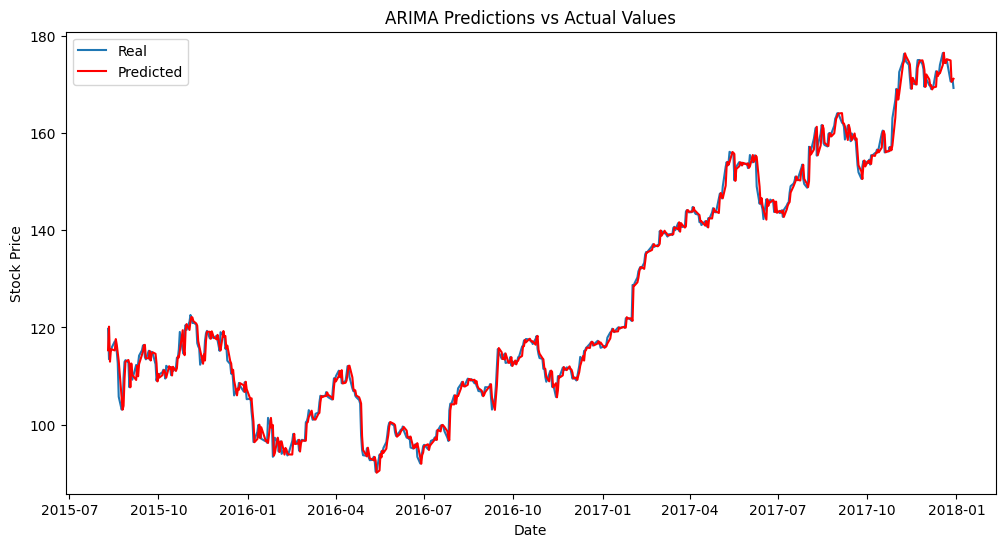

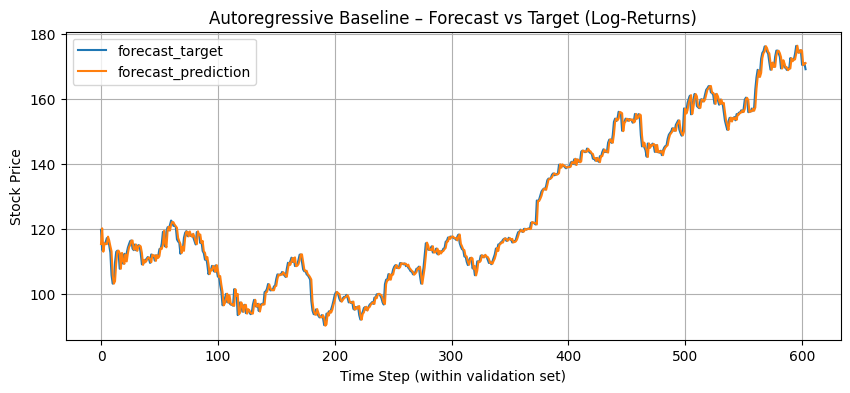

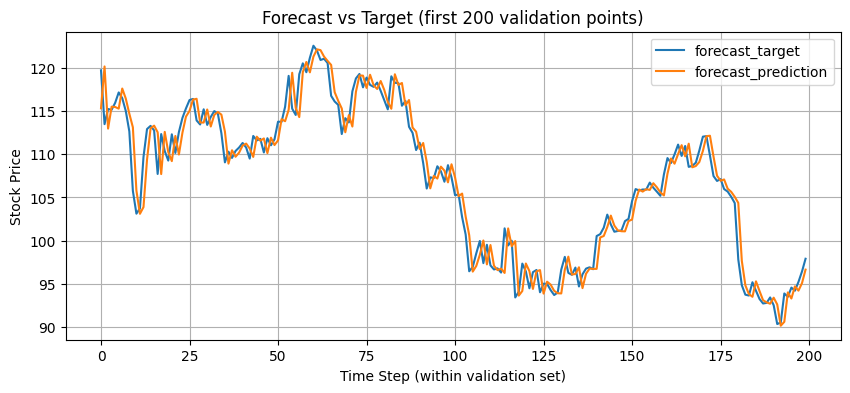

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

n_points = 200
Y_test = test
Y_pred = predictions

mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mse)

print("ARIMA Baseline:")
print(f"MAE  = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(df.iloc[size:,:].index, test, label='Real')
plt.plot(df.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(Y_test, label="forecast_target")
plt.plot(Y_pred, label="forecast_prediction")
plt.xlabel("Time Step (within validation set)")
plt.ylabel("Stock Price")
plt.title("Autoregressive Baseline – Forecast vs Target (Log-Returns)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(Y_test[:n_points], label="forecast_target")
plt.plot(Y_pred[:n_points], label="forecast_prediction")
plt.xlabel("Time Step (within validation set)")
plt.ylabel("Stock Price")
plt.title(f"Forecast vs Target (first {n_points} validation points)")
plt.legend()
plt.grid(True)
plt.show()